/Users/Gorkem/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Gorkem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


Time to read data: 0.010062408000003131 seconds
Time to preprocess 2951 data points: 1.017363693 seconds
Time to preprocess 1266 data points: 0.37066819600000045 seconds
Top 10 most common words are: [('eur', 900), ('company', 490), ('mn', 440), ('finnish', 320), ('sales', 307), ('said', 306), ('profit', 298), ('million', 292), ('net', 280), ('year', 262)]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.31106001  0.47663999  0.12986    ...  0.073349    0.27316001
  -0.79343998]
 [ 0.60631001 -0.37365001 -0.31874001 ... -0.35591999  1.00189996
   0.14789   ]
 ...
 [ 0.093759   -0.025291    0.15722001 ...  0.59522998  0.23089001
   0.26718   ]
 [-0.10076     0.64577001 -0.081351   ... -0.15046     0.074236
  -0.037193  ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Total vocabulary size=  6683
Number of words found=  5925
Model: "sequential_1"
_________________________________________________________________
Layer (type)         

'\nKeras LSTM Model Report:\n\nTime to read data: 0.012889714000039021 seconds\nTime to preprocess 2951 data points: 0.77431815500006 seconds\nTime to preprocess 1266 data points: 0.3313503300000775 seconds\nTop 10 most common words are: [(\'eur\', 900), (\'company\', 490), (\'mn\', 440), (\'finnish\', 320), (\'sales\', 307), (\'said\', 306), (\'profit\', 298), (\'million\', 292), (\'net\', 280), (\'year\', 262)]\nModel: "sequential_10"\n_________________________________________________________________\nLayer (type)                 Output Shape              Param #   \n=================================================================\nembedding_10 (Embedding)     (None, 24, 100)           668300    \n_________________________________________________________________\nlstm_10 (LSTM)               (None, 96)                75648     \n_________________________________________________________________\ndropout_10 (Dropout)         (None, 96)                0         \n______________________

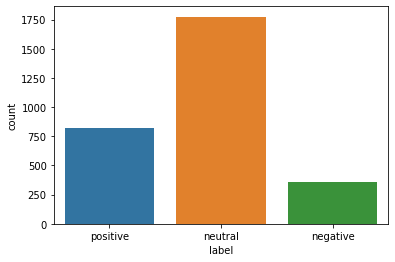

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas
import re
import string
from timeit import default_timer as timer


import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from numpy import zeros
import numpy as np
from keras import models
from keras import layers
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding

from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

np.random.seed(1)

from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import collections
NB_WORDS = 5000  # Parameter indicating the number of words we'll put in the dictionary
EPOCHS = 8 # Number of epochs we usually start to train with
BATCH_SIZE = 96  # Size of the batches used in the mini-batch gradient descent

def read_data():
    """
    Read train/test data

    Returns:
    train -- Training dataframe, with 'sentence' and 'label'
    test -- Testing dataframe, with 'sentence' and 'label'
    """
    start = timer()
    train = pandas.read_csv("training_data.csv", sep = "\t", encoding = "utf-8")
    
    test = pandas.read_csv("testing_data.csv", sep = "\t", encoding = "utf-8")

    end = timer()
    print ("Time to read data: {} seconds".format(end - start))
    
    sns.countplot(x='label', data=train)
    return train,test

def preprocess_data(df):
    """
    Preprocess data:
    -- strip spaces and lowercase
    -- get rid of numbers
    -- get rid of punctuations
    -- get rid of single letters

    Keyword arguments:
    df -- Input two column dataframe with 'sentence' and 'label'

    Returns:
    df -- With preprocessed 'sentence' column and 'label'
    """
    
    def preprocessor(sentence):
        sentence = sentence.strip().lower()
        sentence = re.sub(r"\d+", "", sentence)
        sentence = sentence.translate(sentence.maketrans(string.punctuation, ' '*len(string.punctuation)))
        sentence = " ".join([w for w in nltk.word_tokenize(sentence) if len(w) > 1])

        return sentence
    
    def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
   
    start = timer()
    df["sentence"] = df["sentence"].apply(preprocessor)
    df["sentence"] = df["sentence"].apply(remove_stopwords).apply(remove_mentions)
    
    end = timer()
    print ("Time to preprocess {} data points: {} seconds".format(df.shape[0], end - start))
    return df

def train_eval_clf(train_data,test_data):
    """
    Train classifier
    -- logistic regression
    -- with TFIDF features

    Keyword arguments:
    df -- Input two column dataframe with 'sentence' and 'label'

    Returns:
    vec -- Fitted vectorizer
    clf -- Fitted classifier
    """
    
    tokenizer = Tokenizer(num_words=NB_WORDS)
    X_train= train_data["sentence"]
    y_train=train_data["label"]
    X_test= test_data["sentence"]
    y_test=test_data["label"]
    
    
    tokenizer.fit_on_texts(X_train)
    print('Top 10 most common words are:', collections.Counter(tokenizer.word_counts).most_common(10))
    word_index = tokenizer.word_index

    #print("word_index=",word_index)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    vocab_size = len(tokenizer.word_index) + 1
   
    MAX_LEN = 24
    
    X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
    X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)
   
    le = LabelEncoder()
    y_train_le = le.fit_transform(y_train)
    y_test_le = le.transform(y_test)
    y_train_oh = to_categorical(y_train_le)
    y_test_oh = to_categorical(y_test_le)
    
    
    embeddings_index = {}
    f = open('glove.6B.100d.txt')
    for line in f:
        
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    k=0
    embedding_matrix = np.zeros((len(word_index) + 1, 100))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            k+=1
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    print(embedding_matrix)
    print("Total vocabulary size= ",vocab_size)
    print("Number of words found= ",k)
    
    glove_model = models.Sequential()
    glove_model.add(layers.Embedding(len(word_index) + 1, 100, input_length=MAX_LEN, weights=[embedding_matrix],trainable=False))
    glove_model.add(layers.LSTM(96))
    glove_model.add(layers.Dropout(0.20))
    glove_model.add(layers.Dense(3, activation='softmax'))
    glove_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    glove_model.summary()


    glove_history = glove_model.fit(X_train_pad, y_train_oh, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                              validation_data=(X_test_pad, y_test_oh))
    glove_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    
    test_model = glove_model.evaluate(X_test_pad, y_test_oh)
    print('Test accuracy is {0:.2f}%'.format(test_model[1] * 100))
    

    end = timer()
    

if __name__ == "__main__":
    train, test = read_data()
    train = preprocess_data(train)
    test = preprocess_data(test)
    train_eval_clf(train,test)
   

"""
Keras LSTM Model Report:

Time to read data: 0.012889714000039021 seconds
Time to preprocess 2951 data points: 0.77431815500006 seconds
Time to preprocess 1266 data points: 0.3313503300000775 seconds
Top 10 most common words are: [('eur', 900), ('company', 490), ('mn', 440), ('finnish', 320), ('sales', 307), ('said', 306), ('profit', 298), ('million', 292), ('net', 280), ('year', 262)]
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
embedding_10 (Embedding)     (None, 24, 100)           668300    
_________________________________________________________________
lstm_10 (LSTM)               (None, 96)                75648     
_________________________________________________________________
dropout_10 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 291       
=================================================================
Total params: 744,239
Trainable params: 75,939
Non-trainable params: 668,300
_________________________________________________________________
Train on 2951 samples, validate on 1266 samples
Epoch 1/8
2951/2951 [==============================] - 1s 427us/step - loss: 0.8437 - accuracy: 0.6384 - val_loss: 0.7535 - val_accuracy: 0.6809
Epoch 2/8
2951/2951 [==============================] - 1s 286us/step - loss: 0.6965 - accuracy: 0.7055 - val_loss: 0.6769 - val_accuracy: 0.7101
Epoch 3/8
2951/2951 [==============================] - 1s 282us/step - loss: 0.6195 - accuracy: 0.7404 - val_loss: 0.6490 - val_accuracy: 0.7267
Epoch 4/8
2951/2951 [==============================] - 1s 279us/step - loss: 0.5730 - accuracy: 0.7604 - val_loss: 0.6422 - val_accuracy: 0.7472
Epoch 5/8
2951/2951 [==============================] - 1s 271us/step - loss: 0.5146 - accuracy: 0.7899 - val_loss: 0.6201 - val_accuracy: 0.7559
Epoch 6/8
2951/2951 [==============================] - 1s 282us/step - loss: 0.4671 - accuracy: 0.8113 - val_loss: 0.6138 - val_accuracy: 0.7528
Epoch 7/8
2951/2951 [==============================] - 1s 271us/step - loss: 0.4259 - accuracy: 0.8319 - val_loss: 0.6308 - val_accuracy: 0.7551
Epoch 8/8
2951/2951 [==============================] - 1s 277us/step - loss: 0.4067 - accuracy: 0.8370 - val_loss: 0.6124 - val_accuracy: 0.7717
1266/1266 [==============================] - 0s 155us/step
Test accuracy is 77.17%

"""


